# Raport 2

### Zaimplementowane biblioteki

In [51]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy as sp
import pandas as pd
import statsmodels.stats as sm

from statsmodels.tsa.arima_process import ArmaProcess, arma_acovf, arma_acf, arma_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acovf, acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import  acorr_ljungbox
from statsmodels.stats.diagnostic import  het_arch

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit


### Dane

0       17.5
1       12.7
2       17.4
3       16.8
4       13.0
        ... 
1457    16.0
1458    14.7
1459    13.9
1460    13.3
1461    17.3
Name: tmax, Length: 1462, dtype: float64

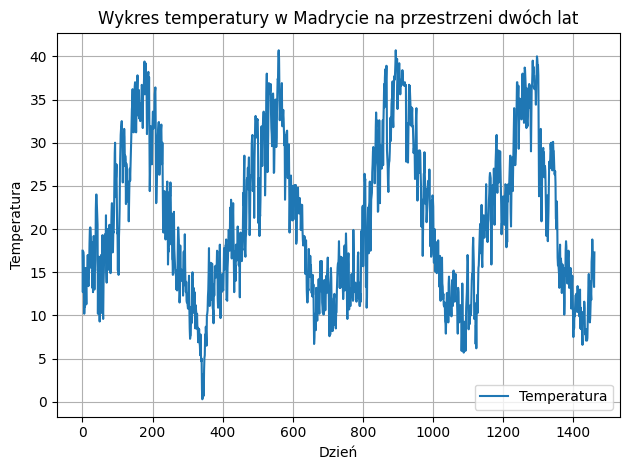

In [52]:
plt.rcParams['text.usetex'] = False
data = pd.read_csv('export.csv')
values = data['tmax']
plt.plot(values, label='Temperatura')
plt.legend()
plt.ylabel('Temperatura')
plt.xlabel('Dzień')
plt.title('Wykres temperatury w Madrycie na przestrzeni dwóch lat')
plt.tight_layout()
plt.grid()
len(values)
values

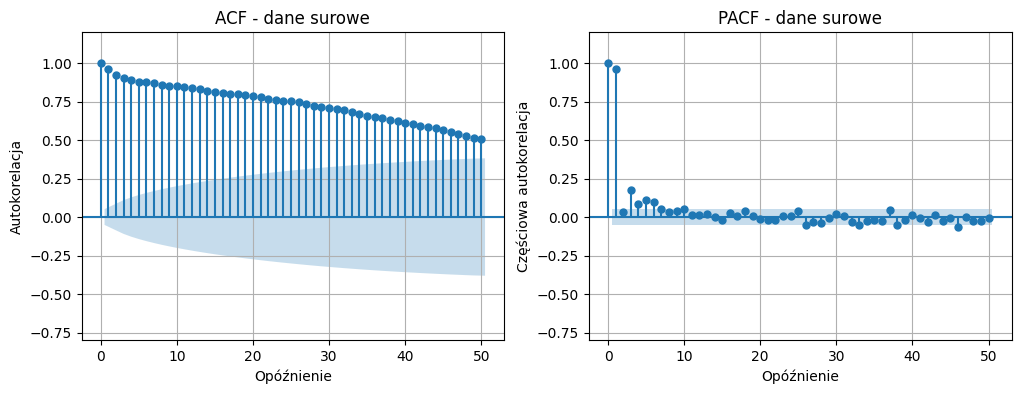

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(values, lags=50, ax=axes[0])
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Autokorelacja')
axes[0].set_title('ACF - dane surowe')
axes[0].set_ylim(-0.8, 1.2)
axes[0].grid()

plot_pacf(values, lags=50, ax=axes[1])
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Częściowa autokorelacja')
axes[1].set_title('PACF - dane surowe')
axes[1].set_ylim(-0.8, 1.2)
axes[1].grid()


In [54]:
def adfuller_test(series, sig = 0.05):
    res = adfuller(series, autolag='AIC')    
    p_value = round(res[1], 3) 
    stats   = round(res[0], 3) 

    if p_value <= sig:
        print(f"Statystyka testowa = {stats}, p-Value = {p_value} => Stationary. ")
    else:
        print(f"Statystyka testowa = {stats}, p-value = {p_value} => Non-stationary.")

adfuller_test(values)

Statystyka testowa = -2.586, p-value = 0.096 => Non-stationary.


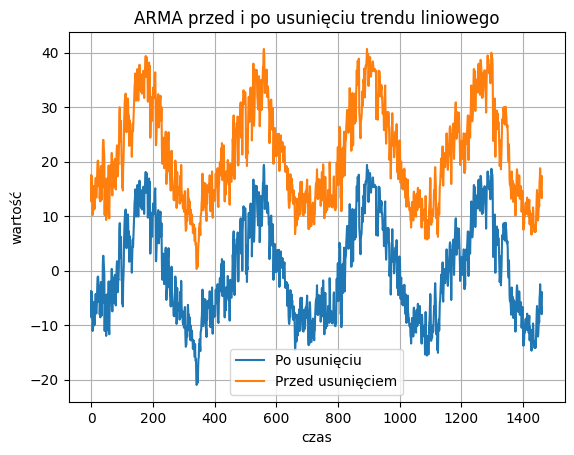

In [94]:

time = np.arange(len(values))
linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), values)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))
wotrend = values - trend_predicted
plt.plot(wotrend, label='Po usunięciu')
plt.plot(values, label = 'Przed usunięciem')
plt.xlabel('czas')
plt.ylabel('wartość')
plt.title('ARMA przed i po usunięciu trendu liniowego')
plt.legend()
plt.grid()

array([1.14651058e+01, 1.72295479e-02, 1.52121173e+02])

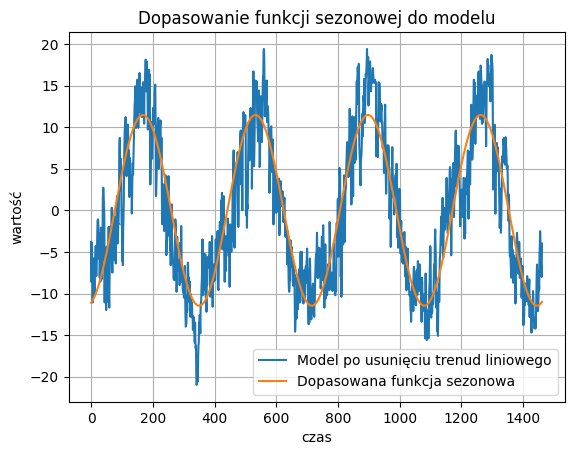

In [96]:
def sine_func(x, A, omega, k):
    return A * np.sin(omega*x-k)

p0 = [8, 2 * np.pi / 365, 150]
params, _ = curve_fit(sine_func, time, wotrend, p0=p0)
fitted_sine_wave = sine_func(time, *params)

end = wotrend - fitted_sine_wave

plt.plot(wotrend, label='Model po usunięciu trenud liniowego')
plt.plot(fitted_sine_wave, label='Dopasowana funkcja sezonowa')
plt.xlabel('czas')
plt.ylabel('wartość')
plt.title('Dopasowanie funkcji sezonowej do modelu')
plt.legend()
plt.grid()
params

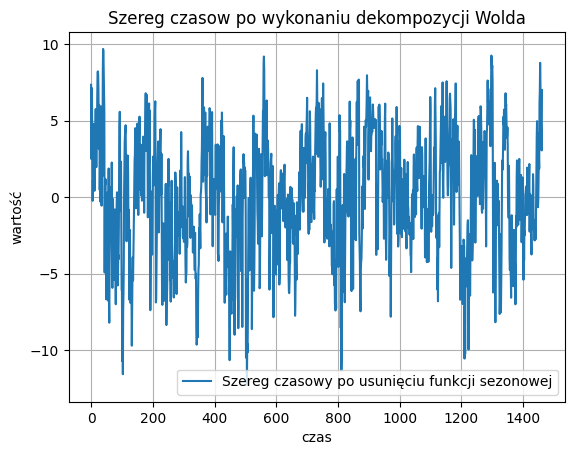

In [98]:
plt.plot(end, label='Szereg czasowy po usunięciu funkcji sezonowej')
plt.xlabel('czas')
plt.ylabel('wartość')
plt.title('Szereg czasow po wykonaniu dekompozycji Wolda')
plt.legend()
plt.grid()

In [99]:
adfuller_test(end)

Statystyka testowa = -8.667, p-Value = 0.0 => Stationary. 


In [82]:
# Za pomocą kryteriow informacyjnych szukamy rzędu modelu, rozważamy ARMA(p,q), gdzie p, q = {0, 1, 2, 3}

df = pd.DataFrame()

ps = []
qs = []
BIC = []
AIC = []
HQIC = []

# Maksymalne wartości p i q
max_p = 3
max_q = 3

# Iteracja po możliwych wartościach p i q
for p in range(0, max_p):
    for q in range(0, max_q):
        
        # Dopasowanie modelu ARMA dla danego p i q
        model = ARIMA(end, order=(p, 0, q))
        model_fit = model.fit()
        
        # Zapisanie wartości p, q oraz wyników kryteriów informacyjnych
        ps.append(p)
        qs.append(q)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
        HQIC.append(model_fit.hqic)

df['p']    = ps
df['q']    = qs
df['AIC']  = AIC
df['BIC']  = BIC
df['HQIC'] = HQIC

df.sort_values(by='AIC').head(3)


C:\Users\komputer\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\komputer\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p,q,AIC,BIC,HQIC
8,2,2,6665.815249,6697.540613,6677.649276
5,1,2,6674.147562,6700.585365,6684.009251
7,2,1,6682.336903,6708.774706,6692.198592


In [83]:
df.sort_values(by='BIC').head(3)

,p,q,AIC,BIC,HQIC
8,2,2,6665.815249,6697.540613,6677.649276
5,1,2,6674.147562,6700.585365,6684.009251
3,1,0,6689.078522,6704.941204,6694.995536


In [84]:
df.sort_values(by='HQIC').head(3)

,p,q,AIC,BIC,HQIC
8,2,2,6665.815249,6697.540613,6677.649276
5,1,2,6674.147562,6700.585365,6684.009251
7,2,1,6682.336903,6708.774706,6692.198592


<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\p'
<>:16: SyntaxWarning: invalid escape sequence '\T'
<>:16: SyntaxWarning: invalid escape sequence '\T'
C:\Users\komputer\AppData\Local\Temp\ipykernel_6272\535336410.py:16: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([0,1,2,3])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_6272\535336410.py:16: SyntaxWarning: invalid escape sequence '\p'
  plt.xticks(range(len([0,1,2,3])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
C:\Users\komputer\AppData\Local\Temp\ipykernel_6272\535336410.py:16: SyntaxWarning: invalid escape sequence '\T'
  plt.xticks(range(len([0,1,2,3])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$'

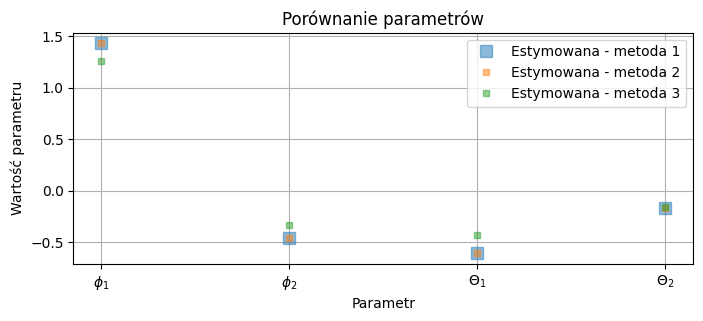

ar.L1    1.429960
ar.L2   -0.463927
ma.L1   -0.606997
ma.L2   -0.168802
dtype: float64

In [107]:
p, q = 2,2
model_first_method = ARIMA(end, order=(p, 0, q)).fit(method='statespace')
model_second_method = ARIMA(end, order=(p, 0, q)).fit(method='innovations_mle')
model_third_method = ARIMA(end, order=(p, 0, q)).fit(method='hannan_rissanen')

plt.figure(figsize=(8,3))

#plt.plot([p1, p2, q1, q2], 'o', markersize=10, alpha=0.5, label='Prawdziwa')
plt.plot(model_first_method.params[1:-1], 's', markersize=8, alpha=0.5, label='Estymowana - metoda 1')
plt.plot(model_second_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 2')
plt.plot(model_third_method.params[1:-1], 's', markersize=5, alpha=0.5, label='Estymowana - metoda 3')
plt.legend()
plt.xlabel('Parametr')
plt.ylabel('Wartość parametru')
plt.title('Porównanie parametrów')
plt.xticks(range(len([0,1,2,3])), ['$\phi_1$', '$\phi_2$', '$\Theta_1$', '$\Theta_2$'])
plt.grid()
plt.show()
model_first_method.params[1:-1]


In [101]:
p1 = 1.429960
p2 = -0.463927
q1 = -0.606997
q2 = -0.168802

ar_coef = np.array([1, -p1, -p2])
ma_coef = np.array([1, q1, q2])
arma_process = ArmaProcess(ar_coef, ma_coef)
h_max = 50


acf_teor_ = arma_process.acf(lags = h_max + 1) # korzystamy z funkcji arma_acf
pacf_teor_ = arma_process.pacf(lags = h_max + 1) 

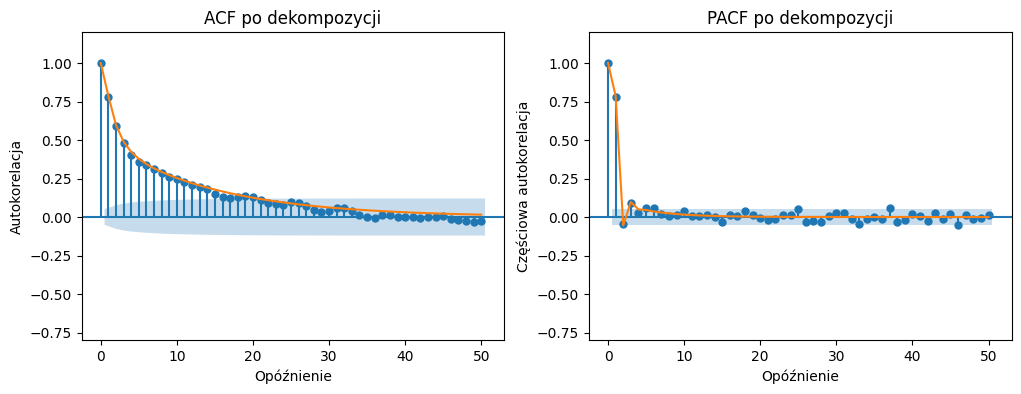

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(end, lags=50, ax=axes[0])
axes[0].set_xlabel('Opóźnienie')
axes[0].set_ylabel('Autokorelacja')
axes[0].set_title('ACF po dekompozycji')
axes[0].set_ylim(-0.8, 1.2)
axes[0].plot(acf_teor_)

plot_pacf(end, lags=50, ax=axes[1])
axes[1].set_xlabel('Opóźnienie')
axes[1].set_ylabel('Częściowa autokorelacja')
axes[1].set_title('PACF po dekompozycji')
axes[1].set_ylim(-0.8, 1.2)
axes[1].plot(pacf_teor_)

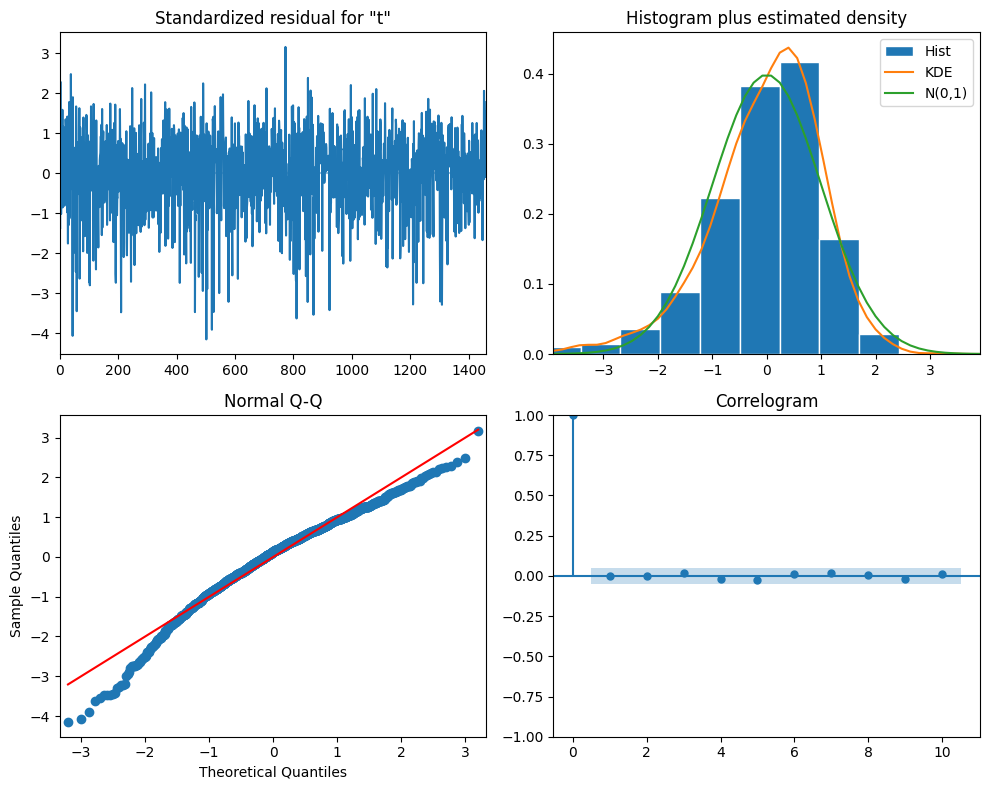

In [110]:
model_first_method.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()

In [90]:
np.mean(end)
sp.stats.ttest_ind(end, 0)

TtestResult(statistic=0.006510424032529743, pvalue=0.9948063586902767, df=1461.0)

In [70]:
acorr_ljungbox(end)

,lb_stat,lb_pvalue
1,896.537032,5.554307e-197
2,1412.559868,1.847234e-307
3,1755.054398,0.000000e+00
4,1996.791806,0.000000e+00
5,2186.976451,0.000000e+00
6,2354.574769,0.000000e+00
7,2499.352673,0.000000e+00
8,2618.461477,0.000000e+00
9,2716.496596,0.000000e+00
10,2804.904649,0.000000e+00


In [71]:
het_arch(end)

(496.65069861837327,
 2.2938643010991485e-100,
 74.91224996700873,
 1.6115078112593144e-123)

In [72]:
sp.stats.shapiro(end)

ShapiroResult(statistic=0.995395302772522, pvalue=0.00019223254639655352)

In [73]:
sp.stats.jarque_bera(end)

SignificanceResult(statistic=13.412539573954765, pvalue=0.0012232184904860319)